### Script to correlate estimates from cognitive models with brain acitvyt from ROI analysis

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
import shutil
import itertools
import statannot
import scipy

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
import nideconv
from nideconv import GroupResponseFitter
from scipy import signal
from scipy.stats.stats import pearsonr

import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.backends.backend_pdf

%matplotlib inline

def flatten(t):
    return [item for sublist in t for item in sublist]

/home/scotti/.local/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/tmp/ipykernel_1196687/3131838711.py:23: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
# some functions to load data
def load_single_msit(): # load PMWG msit model used in paper
    
    cogmod = pd.read_csv(f'scott/single_msit_params.tsv',sep=',')
    cogmod['subject'] = cogmod.index
    cogmod.subject = cogmod.subject.astype(str)
    
    return cogmod

def load_betas(contrast): # load ROI activity
    
    betas = pd.read_csv(f'scott/{contrast}_betas_tsv.tsv',sep='\t')
    betas.subject = betas.subject.astype(str)
    
    return betas

# def load_cogmod(): # joint model not used in paper
    
#     cogmod = pd.read_csv(f'scott/joint_model_params.tsv',sep='\t')
#     cogmod['subject'] = cogmod.index
#     cogmod['SSRT'] = cogmod['SST|muS'] + cogmod['SST|tauS']
#     cogmod.subject = cogmod.subject.astype(str)
    
#     return cogmod

def load_mean_ssrt(): # load SSRT estimates using mean method
    ssrt = pd.read_csv('scott/mean_ssrt.tsv', sep='\t')
    return ssrt

def load_dmc_params(): # load DMC sst model used in paper
    
    dmc = pd.read_csv('scott/dmc_params_final.tsv', sep='\t') 
    dmc.drop(dmc.tail(1).index,inplace=True) # drop last n rows dmc.reset_index() 
    dmc['SSRT'] = dmc['muS'] + dmc['tauS']
    return dmc

# SST

First correlate SSRT calcuated using BEESTS with SS, SS > GO, FS > SS 

Second, correlate SSRT calcuated using the mean method with SS, SS > GO, FS > SS 



# MEAN METHOD

### SSRT (mean method) vs SS

30
SSRT
 r = 1.0
 p = 0.0
Ins-r
 r = -0.381896330966577
 p = 0.03729442480162401
CN-l
 r = 0.42667576435265364
 p = 0.018704815398386036
RN-r
 r = -0.3669190637227723
 p = 0.046099292904421225
SN-r
 r = -0.40405558690542837
 p = 0.02679744951556041
STN-l
 r = -0.39868232411442395
 p = 0.02908932616885693
STN-r
 r = -0.48873083259004896
 p = 0.006135554098755243
VTA-r
 r = -0.46494976328296866
 p = 0.009631288621385334
              t         p fdr_significant  p_corrected
IFG-l  0.302831  0.103811           False        0.121
IFG-r -0.047264  0.804124           False        0.804
SN-l  -0.330986  0.074003           False        0.104
SN-r  -0.404056  0.026797           False        0.051
SSRT   1.000000  0.000000            True        0.000
STN-l -0.398682  0.029089           False        0.051
STN-r -0.488731  0.006136            True        0.021


/home/scotti/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


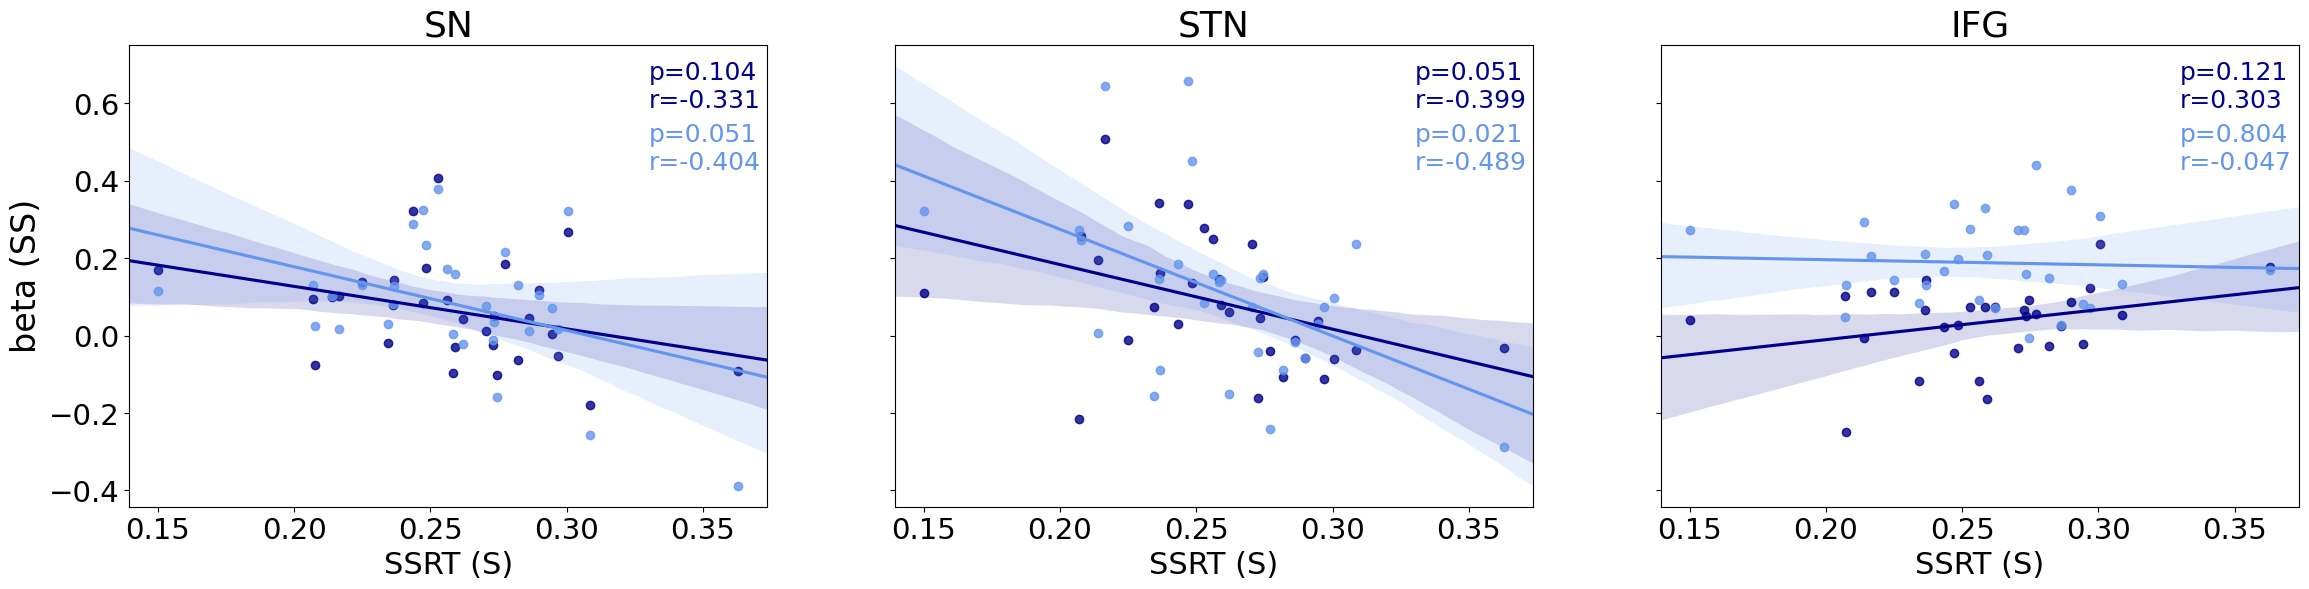

In [93]:
betas = load_betas('ss')
cog = load_mean_ssrt()
cog.columns = ['subject','SSRT']
cog.subject = cog.subject.astype(str)

all_subs = sorted(list(set(betas.subject).intersection(cog.subject)),key=int)
print(len(all_subs)) # there should be 31

cog = cog.loc[cog.subject.isin(all_subs)].reset_index(drop=True)
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

cog_betas = pd.concat([cog, betas], axis=1)
cog_betas = cog_betas.loc[:,~cog_betas.columns.duplicated()]


# corr = cog_betas.corr()
# corr.style.background_gradient(cmap='coolwarm')

for i in cog_betas.columns:
    if i == 'subject':
        continue
    r, p = pearsonr(cog_betas['SSRT'], cog_betas[i])
    if p <= 0.05:
        print(f'{i}\n r = {r}\n p = {p}')
        
        ## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = cog_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)

print(stat_df)

# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=cog_betas['SSRT'], y=cog_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (SS)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi: 
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.33,0.590),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.33,0.430),fontsize=18,color='cornflowerblue')
#     stat_df.loc[stat_df.index == r,'p_corrected']
# plt.annotate('actual group', xy=(x+0.2,y), xytext=(x+0.3, 300),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7))

### SSRT (mean method) vs ss>go

SSRT
 r = 1.0
 p = 0.0
Str-l
 r = 0.3814025261346892
 p = 0.04521964784718343
              t         p fdr_significant  p_corrected
IFG-l  0.004951  0.980051           False        0.980
IFG-r  0.286643  0.139179           False        0.379
SN-l   0.073856  0.708773           False        0.827
SN-r  -0.247861  0.203475           False        0.379
SSRT   1.000000  0.000000            True        0.000
STN-l -0.162219  0.409524           False        0.573
STN-r -0.241059  0.216558           False        0.379


/home/scotti/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


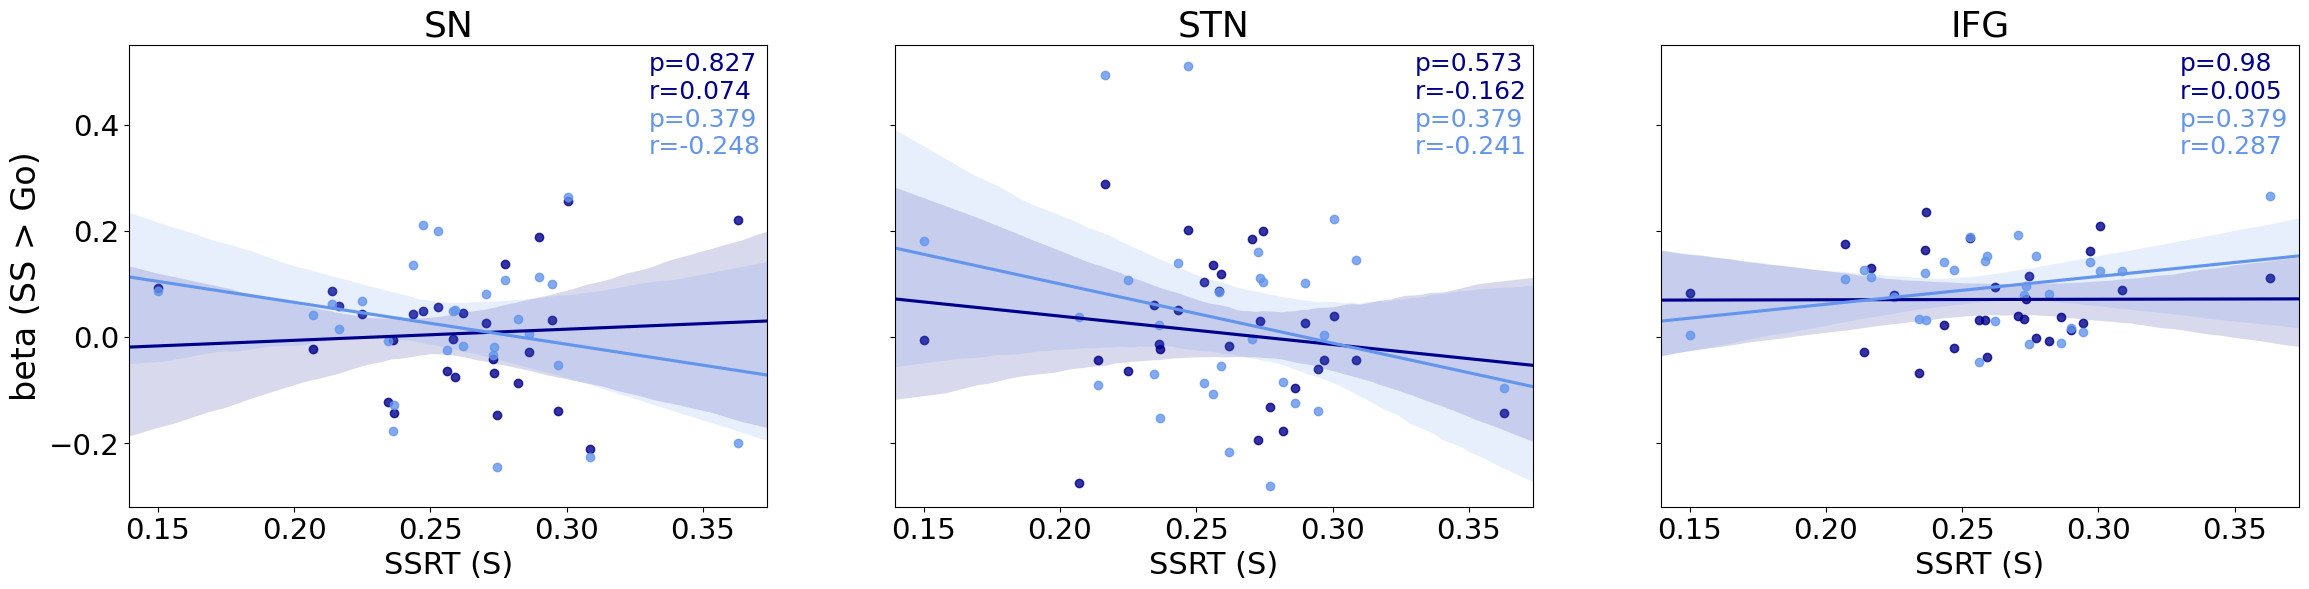

In [77]:
betas_ss = load_betas('ss')
betas_go = load_betas('go')
betas_ss.iloc[:,4:] = betas_ss.iloc[:,4:] - betas_go.iloc[:,4:]
betas = betas_ss

cog = load_mean_ssrt()
cog.columns = ['subject','SSRT']
cog.subject = cog.subject.astype(str)

all_subs = sorted(list(set(betas.subject).intersection(cog.subject)),key=int)

cog = cog.loc[cog.subject.isin(all_subs)].reset_index(drop=True)
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

cog_betas = pd.concat([cog, betas], axis=1)
cog_betas = cog_betas.loc[:,~cog_betas.columns.duplicated()]

for i in cog_betas.columns:
    if i == 'subject':
        continue
    r, p = pearsonr(cog_betas['SSRT'], cog_betas[i])
    if p <= 0.05:
        print(f'{i}\n r = {r}\n p = {p}')
        
## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = cog_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)

print(stat_df)

# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=cog_betas['SSRT'], y=cog_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (SS > Go)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi: 
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.33,0.45),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.33,0.345),fontsize=18,color='cornflowerblue')
#     stat_df.loc[stat_df.index == r,'p_corrected']
# plt.annotate('actual group', xy=(x+0.2,y), xytext=(x+0.3, 300),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7))

### SSRT (mean method) vs fs>ss

SSRT
 r = 1.0
 p = 0.0
Str-l
 r = -0.37515868792327256
 p = 0.04916368538365311
              t         p fdr_significant  p_corrected
IFG-l -0.095533  0.628687           False        0.629
IFG-r -0.246913  0.205265           False        0.610
SN-l  -0.156429  0.426662           False        0.610
SN-r   0.190399  0.331808           False        0.610
SSRT   1.000000  0.000000            True        0.000
STN-l  0.126127  0.522474           False        0.610
STN-r  0.141807  0.471642           False        0.610


/home/scotti/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


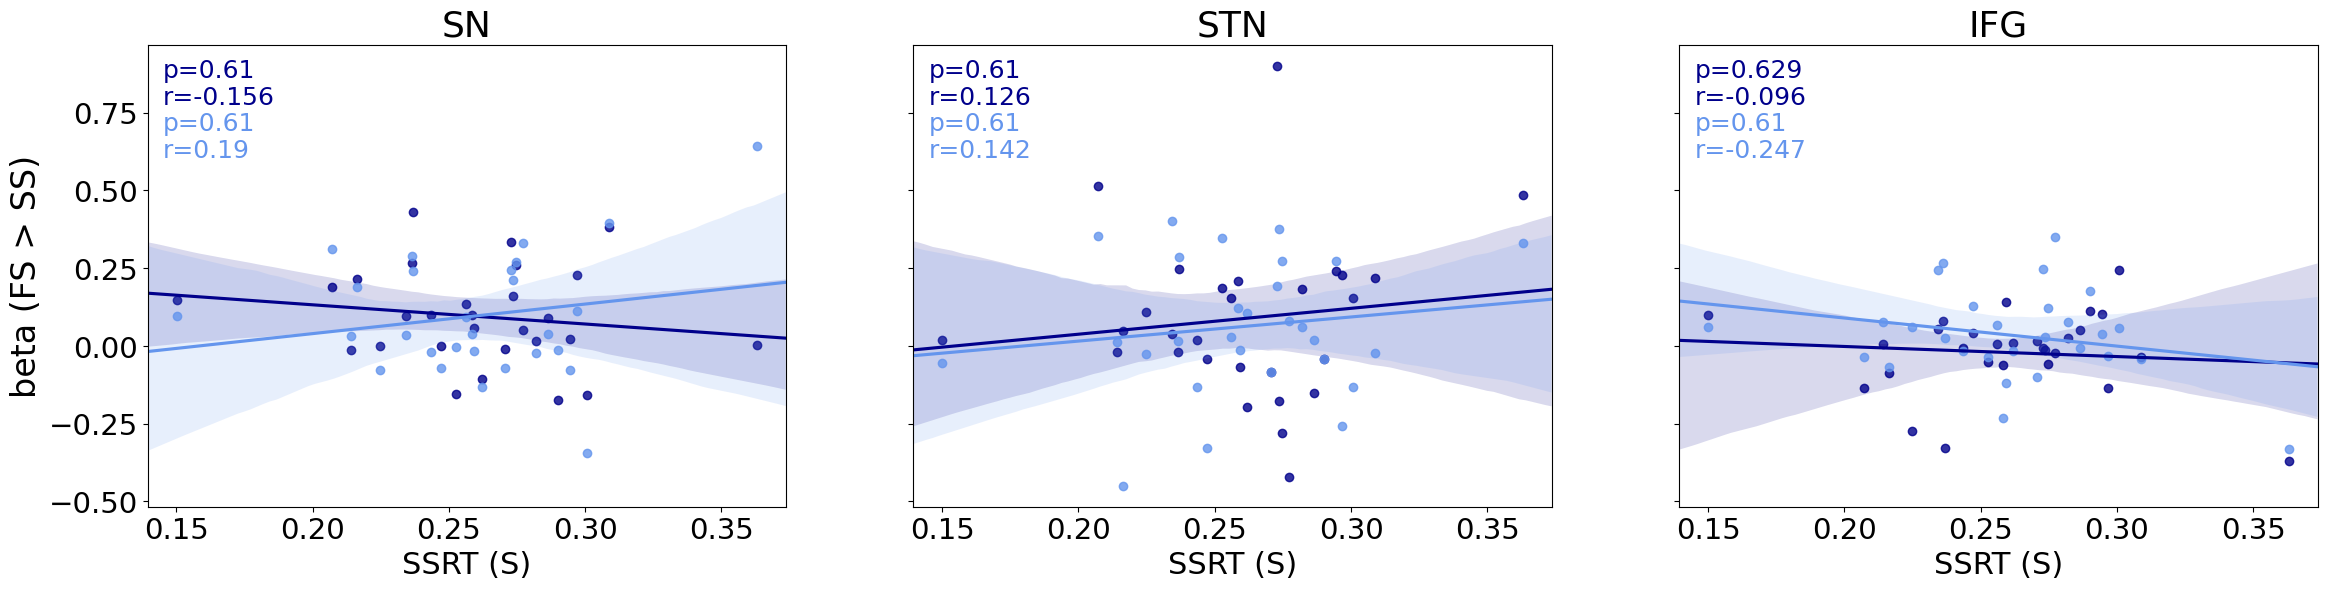

In [63]:
betas_fs = load_betas('fs')
betas_ss = load_betas('ss')
betas_fs.iloc[:,4:] = betas_fs.iloc[:,4:] - betas_ss.iloc[:,4:]
betas = betas_fs

cog = load_mean_ssrt()
cog.columns = ['subject','SSRT']
cog.subject = cog.subject.astype(str)

all_subs = sorted(list(set(betas.subject).intersection(cog.subject)),key=int)

cog = cog.loc[cog.subject.isin(all_subs)].reset_index(drop=True)
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

cog_betas = pd.concat([cog, betas], axis=1)
cog_betas = cog_betas.loc[:,~cog_betas.columns.duplicated()]

for i in cog_betas.columns:
    if i == 'subject':
        continue
    r, p = pearsonr(cog_betas['SSRT'], cog_betas[i])
    if p <= 0.05:
        print(f'{i}\n r = {r}\n p = {p}')
        
## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = cog_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)

print(stat_df)

# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=cog_betas['SSRT'], y=cog_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (FS > SS)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi: 
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.145,0.775),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.145,0.605),fontsize=18,color='cornflowerblue')
#     stat_df.loc[stat_df.index == r,'p_corrected']
# plt.annotate('actual group', xy=(x+0.2,y), xytext=(x+0.3, 300),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7))

# BEESTS METHOD

### SSRT (DMC) vs SS

mu.true
 r = -0.48322250241015746
 p = 0.00792109368076423
sigma.true
 r = -0.39261547029870497
 p = 0.035141030471423855
muS
 r = 0.8833810702100232
 p = 2.2131626012953e-10
sigmaS
 r = 0.39868067371089017
 p = 0.032173915539584104
tauS
 r = 0.9272724156034409
 p = 4.923691023482279e-13
SSRT
 r = 0.9999999999999999
 p = 7.230709203712364e-213
SN-r
 r = -0.37378659073664716
 p = 0.045778628567135875
STN-l
 r = -0.3696858805737389
 p = 0.04840370653264298
              t              p fdr_significant  p_corrected
IFG-l  0.280710   1.402072e-01           False        0.196
IFG-r  0.133646   4.894661e-01           False        0.489
SN-l  -0.333360   7.719867e-02           False        0.135
SN-r  -0.373787   4.577863e-02           False        0.113
SSRT   1.000000  7.230709e-213            True        0.000
STN-l -0.369686   4.840371e-02           False        0.113
STN-r -0.140605   4.669180e-01           False        0.489


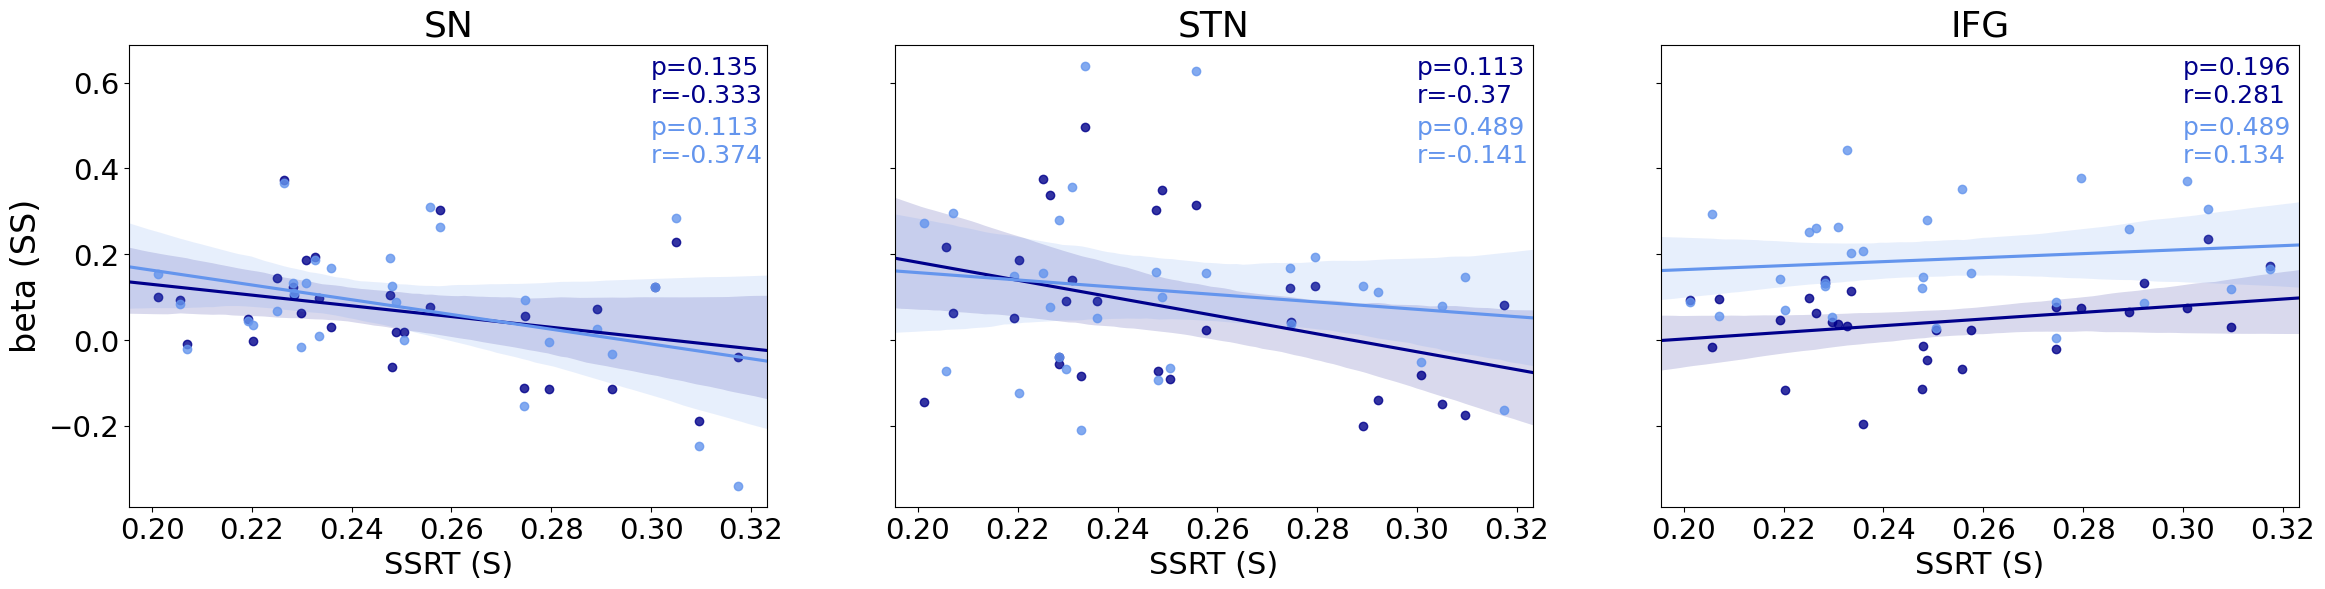

In [65]:
betas = load_betas('ss') 
# dmc = pd.read_csv('scott/dmc_params_final.tsv', sep='\t') 
# dmc.drop(dmc.tail(1).index,inplace=True) # drop last n rows dmc.reset_index() 
# dmc['SSRT'] = dmc['muS'] + dmc['tauS']

dmc = load_dmc_params()

all_subs = sorted(list(set(betas.subject).intersection(dmc.index)),key=int)

dmc = dmc.loc[dmc.index.isin(all_subs)].reset_index(drop=True) 
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

dmc_betas = pd.concat([dmc, betas], axis=1) 
dmc_betas = dmc_betas.loc[:,~dmc_betas.columns.duplicated()]

dmc_betas = dmc_betas.drop(['event type','regressor','covariate'],axis=1)

# show correlations
for i in dmc_betas.columns:
    if i == 'subject':
        continue
    r, p = pearsonr(dmc_betas['SSRT'], dmc_betas[i])
    if p <= 0.05:
        print(f'{i}\n r = {r}\n p = {p}')
        
## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = dmc_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)

print(stat_df)

# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=dmc_betas['SSRT'], y=dmc_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (SS)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(dmc_betas["SSRT"], dmc_betas[this_roi])[0].round(3)}', (0.3,0.555),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(dmc_betas["SSRT"], dmc_betas[this_roi])[0].round(3)}', (0.3,0.415),fontsize=18,color='cornflowerblue')
#     stat_df.loc[stat_df.index == r,'p_corrected']
# plt.annotate('actual group', xy=(x+0.2,y), xytext=(x+0.3, 300),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7))

### SSRT (DMC) vs SS > Go

mu.true
 r = -0.48322250241015746
 p = 0.00792109368076423
sigma.true
 r = -0.39261547029870497
 p = 0.035141030471423855
muS
 r = 0.8833810702100232
 p = 2.2131626012953e-10
sigmaS
 r = 0.39868067371089017
 p = 0.032173915539584104
tauS
 r = 0.9272724156034409
 p = 4.923691023482279e-13
SSRT
 r = 0.9999999999999999
 p = 7.230709203712364e-213
RN-r
 r = 0.4378824580207607
 p = 0.017515027938890624
Str-l
 r = 0.40183755199309673
 p = 0.030711642548216588
              t              p fdr_significant  p_corrected
IFG-l  0.079916   6.802736e-01           False        0.779
IFG-r  0.178007   3.555714e-01           False        0.643
SN-l   0.142951   4.594421e-01           False        0.643
SN-r  -0.148264   4.427460e-01           False        0.643
SSRT   1.000000  7.230709e-213            True        0.000
STN-l  0.054569   7.785964e-01           False        0.779
STN-r  0.196529   3.068766e-01           False        0.643


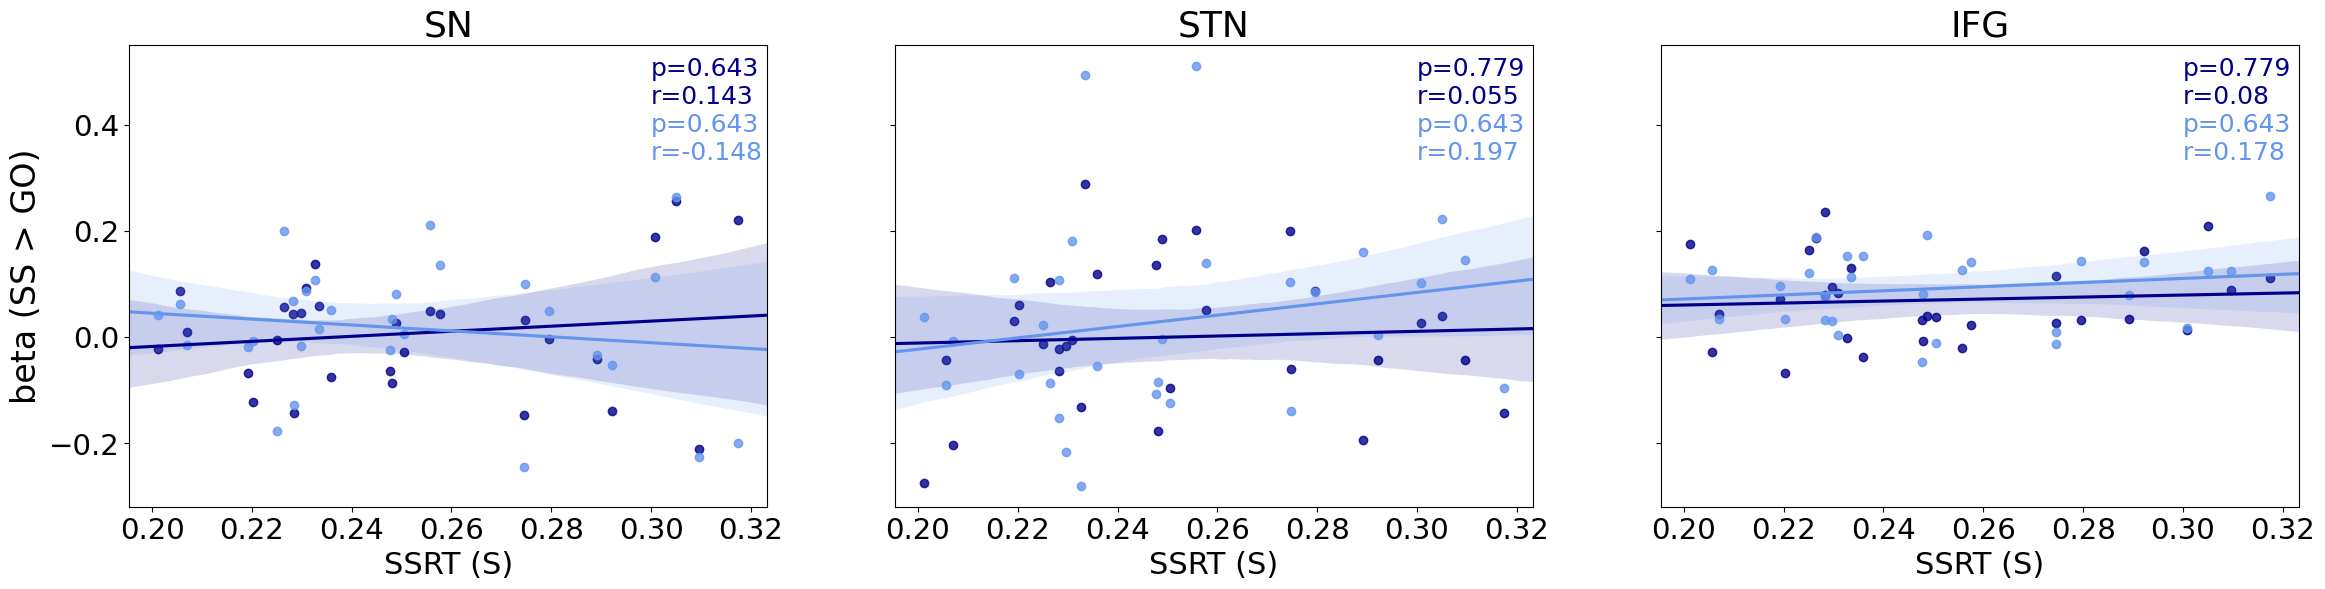

In [83]:
betas_ss = load_betas('ss')
betas_go = load_betas('go')
betas_ss.iloc[:,4:] = betas_ss.iloc[:,4:] - betas_go.iloc[:,4:]
betas = betas_ss
# dmc = pd.read_csv('scott/dmc_params_final.tsv', sep='\t') 
# dmc.drop(dmc.tail(1).index,inplace=True) # drop last n rows dmc.reset_index() 
# dmc['SSRT'] = dmc['muS'] + dmc['tauS']

dmc = load_dmc_params()

all_subs = sorted(list(set(betas.subject).intersection(dmc.index)),key=int)

dmc = dmc.loc[dmc.index.isin(all_subs)].reset_index(drop=True) 
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

dmc_betas = pd.concat([dmc, betas], axis=1) 
dmc_betas = dmc_betas.loc[:,~dmc_betas.columns.duplicated()]

dmc_betas = dmc_betas.drop(['event type','regressor','covariate'],axis=1)

# show correlations
for i in dmc_betas.columns:
    if i == 'subject':
        continue
    r, p = pearsonr(dmc_betas['SSRT'], dmc_betas[i])
    if p <= 0.05:
        print(f'{i}\n r = {r}\n p = {p}')
        
## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = dmc_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)

print(stat_df)

# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=dmc_betas['SSRT'], y=dmc_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (SS > GO)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(dmc_betas["SSRT"], dmc_betas[this_roi])[0].round(3)}', (0.3,0.440),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(dmc_betas["SSRT"], dmc_betas[this_roi])[0].round(3)}', (0.3,0.335),fontsize=18,color='cornflowerblue')
#     stat_df.loc[stat_df.index == r,'p_corrected']
# plt.annotate('actual group', xy=(x+0.2,y), xytext=(x+0.3, 300),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7))

### SSRT (DMC) vs FS > SS

mu.true
 r = -0.48322250241015746
 p = 0.00792109368076423
sigma.true
 r = -0.39261547029870497
 p = 0.035141030471423855
muS
 r = 0.8833810702100232
 p = 2.2131626012953e-10
sigmaS
 r = 0.39868067371089017
 p = 0.032173915539584104
tauS
 r = 0.9272724156034409
 p = 4.923691023482279e-13
SSRT
 r = 0.9999999999999999
 p = 7.230709203712364e-213
GPi-r
 r = 0.44591730715374817
 p = 0.015330609533131822
              t              p fdr_significant  p_corrected
IFG-l -0.008466   9.652360e-01           False        0.965
IFG-r -0.248501   1.936498e-01           False        0.452
SN-l   0.011226   9.539128e-01           False        0.965
SN-r   0.114498   5.542382e-01           False        0.776
SSRT   1.000000  7.230709e-213            True        0.000
STN-l  0.325822   8.455429e-02           False        0.296
STN-r -0.150235   4.366387e-01           False        0.764


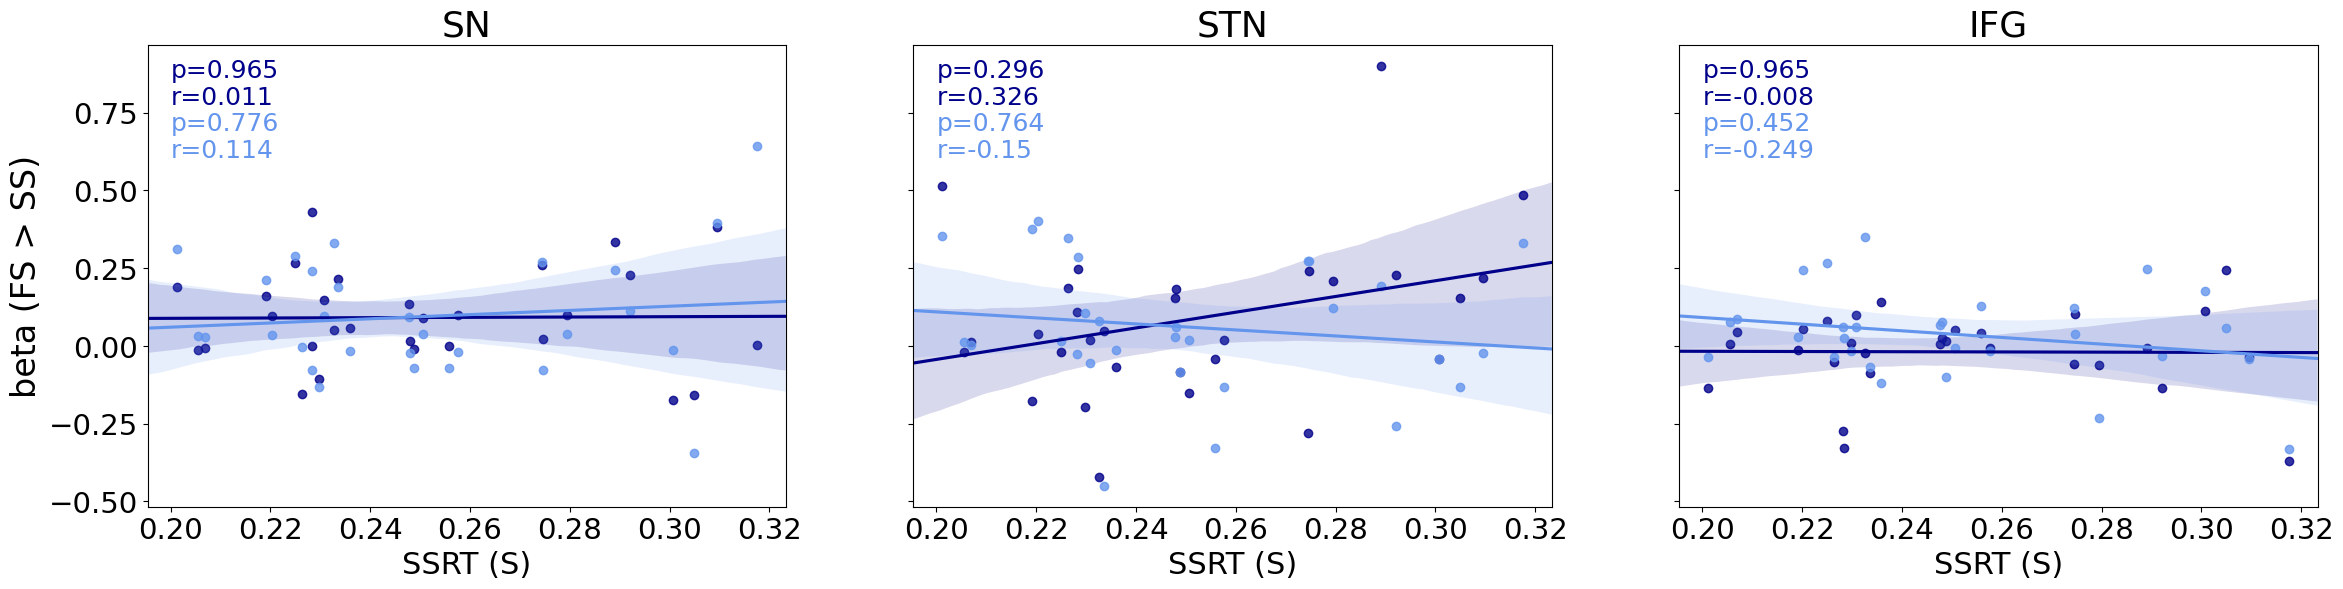

In [82]:
betas_fs = load_betas('fs')
betas_ss = load_betas('ss')
betas_fs.iloc[:,4:] = betas_fs.iloc[:,4:] - betas_ss.iloc[:,4:]
betas = betas_fs
# dmc = pd.read_csv('scott/dmc_params_final.tsv', sep='\t') 
# dmc.drop(dmc.tail(1).index,inplace=True) # drop last n rows dmc.reset_index() 
# dmc['SSRT'] = dmc['muS'] + dmc['tauS']

dmc = load_dmc_params()

all_subs = sorted(list(set(betas.subject).intersection(dmc.index)),key=int)

dmc = dmc.loc[dmc.index.isin(all_subs)].reset_index(drop=True) 
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

dmc_betas = pd.concat([dmc, betas], axis=1) 
dmc_betas = dmc_betas.loc[:,~dmc_betas.columns.duplicated()]

dmc_betas = dmc_betas.drop(['event type','regressor','covariate'],axis=1)

# show correlations
for i in dmc_betas.columns:
    if i == 'subject':
        continue
    r, p = pearsonr(dmc_betas['SSRT'], dmc_betas[i])
    if p <= 0.05:
        print(f'{i}\n r = {r}\n p = {p}')
        
## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = dmc_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)

print(stat_df)

# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=dmc_betas['SSRT'], y=dmc_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (FS > SS)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(dmc_betas["SSRT"], dmc_betas[this_roi])[0].round(3)}', (0.2,0.775),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(dmc_betas["SSRT"], dmc_betas[this_roi])[0].round(3)}', (0.2,0.605),fontsize=18,color='cornflowerblue')
#     stat_df.loc[stat_df.index == r,'p_corrected']
# plt.annotate('actual group', xy=(x+0.2,y), xytext=(x+0.3, 300),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7))

# Put all SST supplementary material graphs together

### meen method

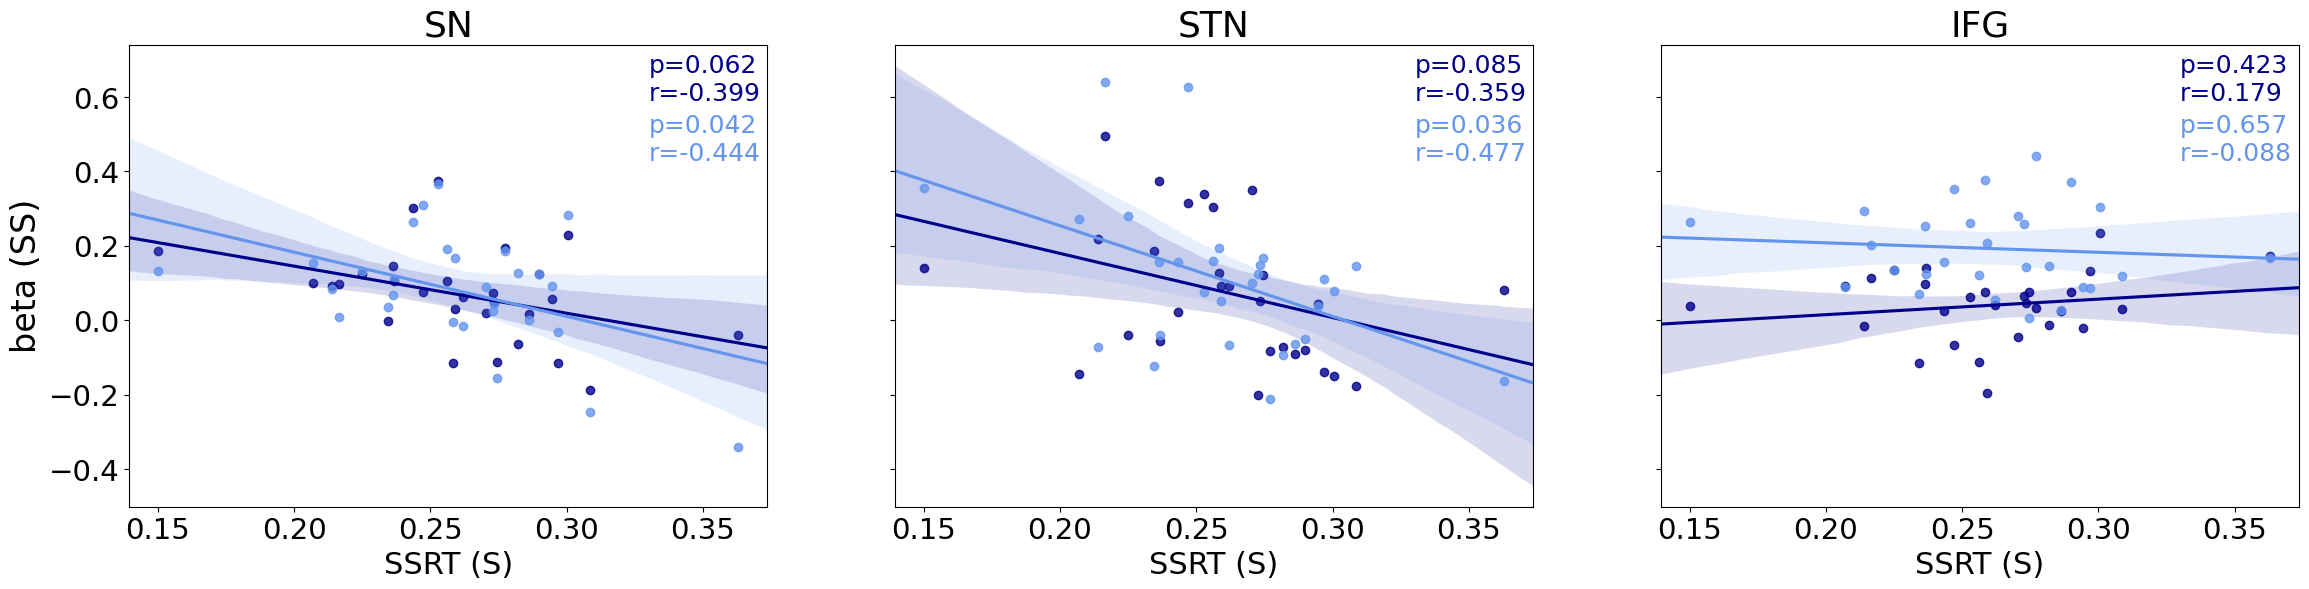

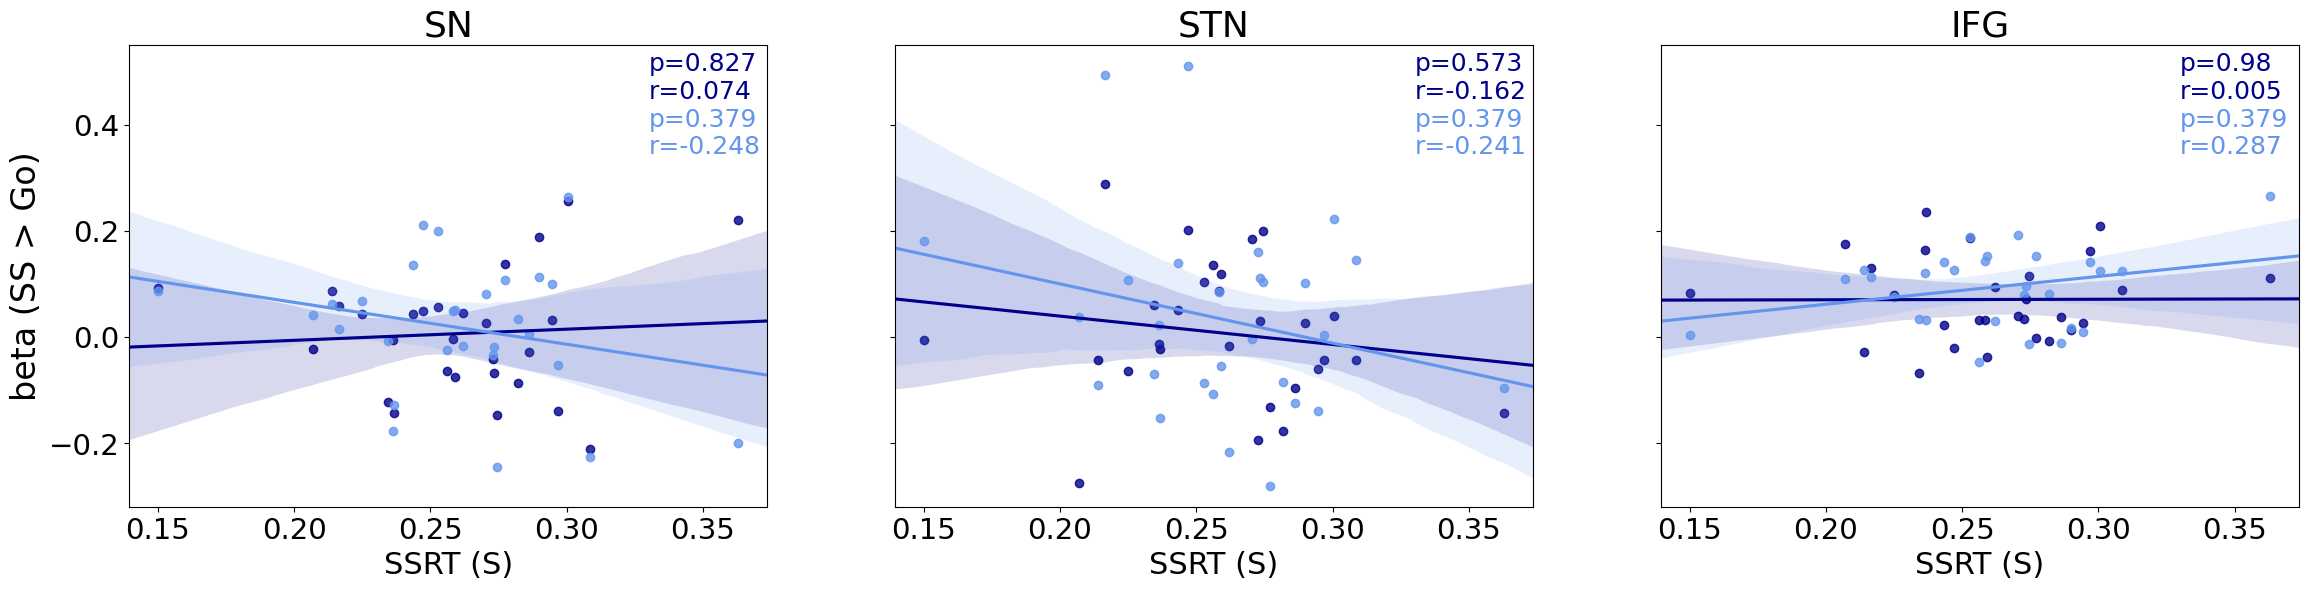

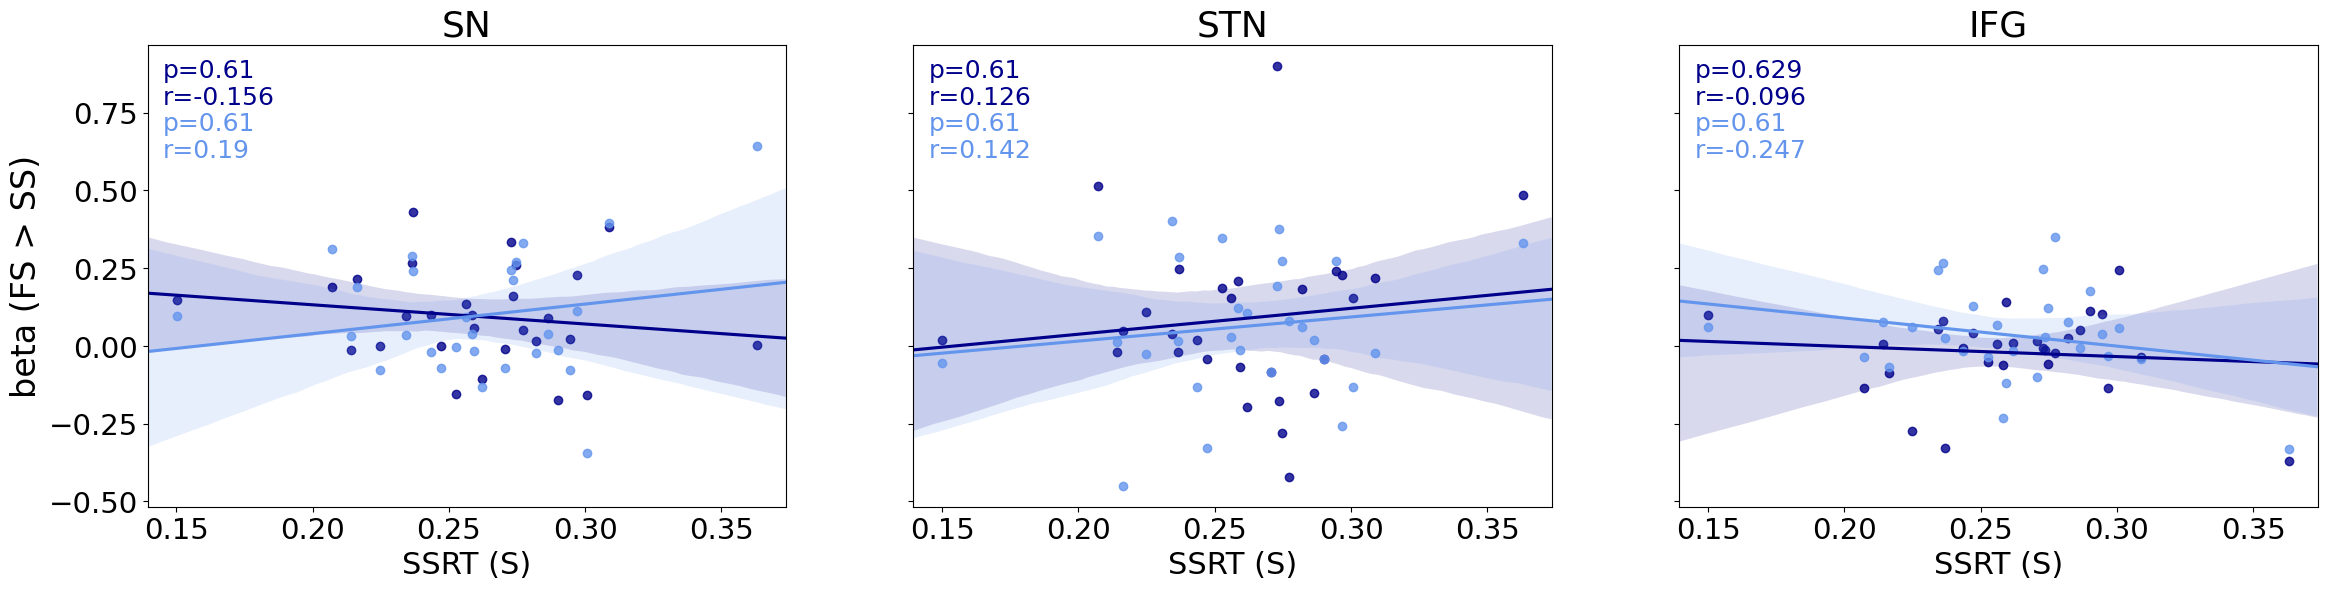

In [80]:
betas = load_betas('ss')
cog = load_mean_ssrt()
cog.columns = ['subject','SSRT']
cog.subject = cog.subject.astype(str)

all_subs = sorted(list(set(betas.subject).intersection(cog.subject)),key=int)

cog = cog.loc[cog.subject.isin(all_subs)].reset_index(drop=True)
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

cog_betas = pd.concat([cog, betas], axis=1)
cog_betas = cog_betas.loc[:,~cog_betas.columns.duplicated()]

        
        ## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = cog_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)


# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=cog_betas['SSRT'], y=cog_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (SS)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi: 
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.33,0.590),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.33,0.430),fontsize=18,color='cornflowerblue')
#     stat_df.loc[stat_df.index == r,'p_corrected']
# plt.annotate('actual group', xy=(x+0.2,y), xytext=(x+0.3, 300),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7))

# ---------------------------------------------

betas_ss = load_betas('ss')
betas_go = load_betas('go')
betas_ss.iloc[:,4:] = betas_ss.iloc[:,4:] - betas_go.iloc[:,4:]
betas = betas_ss

cog = load_mean_ssrt()
cog.columns = ['subject','SSRT']
cog.subject = cog.subject.astype(str)

all_subs = sorted(list(set(betas.subject).intersection(cog.subject)),key=int)

cog = cog.loc[cog.subject.isin(all_subs)].reset_index(drop=True)
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

cog_betas = pd.concat([cog, betas], axis=1)
cog_betas = cog_betas.loc[:,~cog_betas.columns.duplicated()]

        
## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = cog_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)

# print(stat_df)

# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=cog_betas['SSRT'], y=cog_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (SS > Go)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi: 
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.33,0.45),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.33,0.345),fontsize=18,color='cornflowerblue')

# ---------------------------------------------

betas_fs = load_betas('fs')
betas_ss = load_betas('ss')
betas_fs.iloc[:,4:] = betas_fs.iloc[:,4:] - betas_ss.iloc[:,4:]
betas = betas_fs

cog = load_mean_ssrt()
cog.columns = ['subject','SSRT']
cog.subject = cog.subject.astype(str)

all_subs = sorted(list(set(betas.subject).intersection(cog.subject)),key=int)

cog = cog.loc[cog.subject.isin(all_subs)].reset_index(drop=True)
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

cog_betas = pd.concat([cog, betas], axis=1)
cog_betas = cog_betas.loc[:,~cog_betas.columns.duplicated()]
        
## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = cog_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)

# print(stat_df)

# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=cog_betas['SSRT'], y=cog_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (FS > SS)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi: 
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.145,0.775),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_betas["SSRT"], cog_betas[this_roi])[0].round(3)}', (0.145,0.605),fontsize=18,color='cornflowerblue')
#     stat_df.loc[stat_df.index == r,'p_corrected']
# plt.annotate('actual group', xy=(x+0.2,y), xytext=(x+0.3, 300),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7))



### BEESSTS method

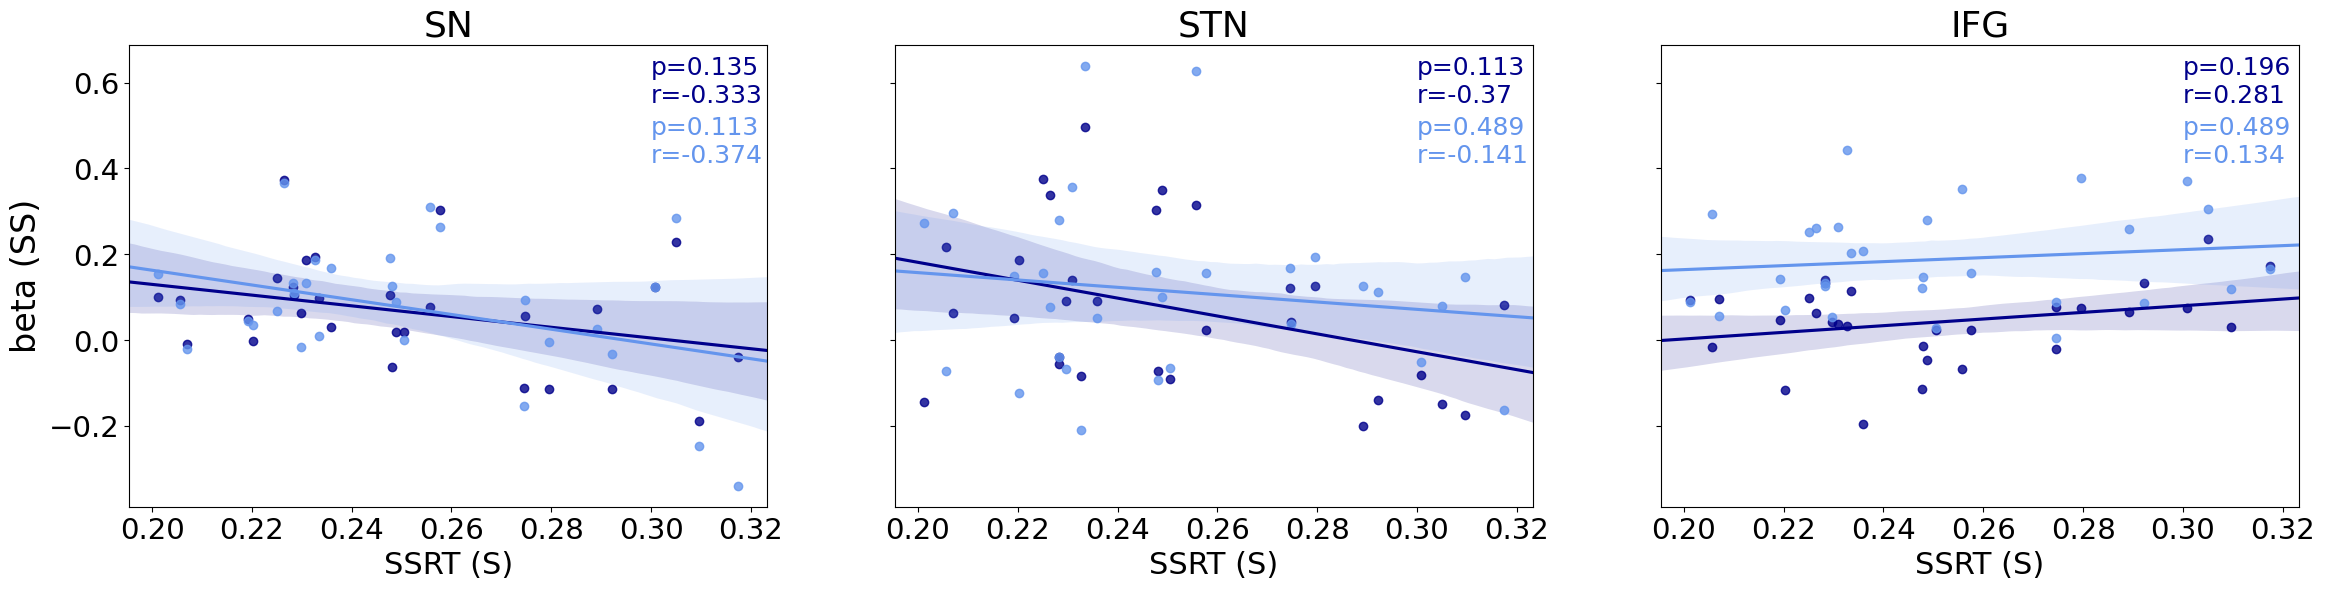

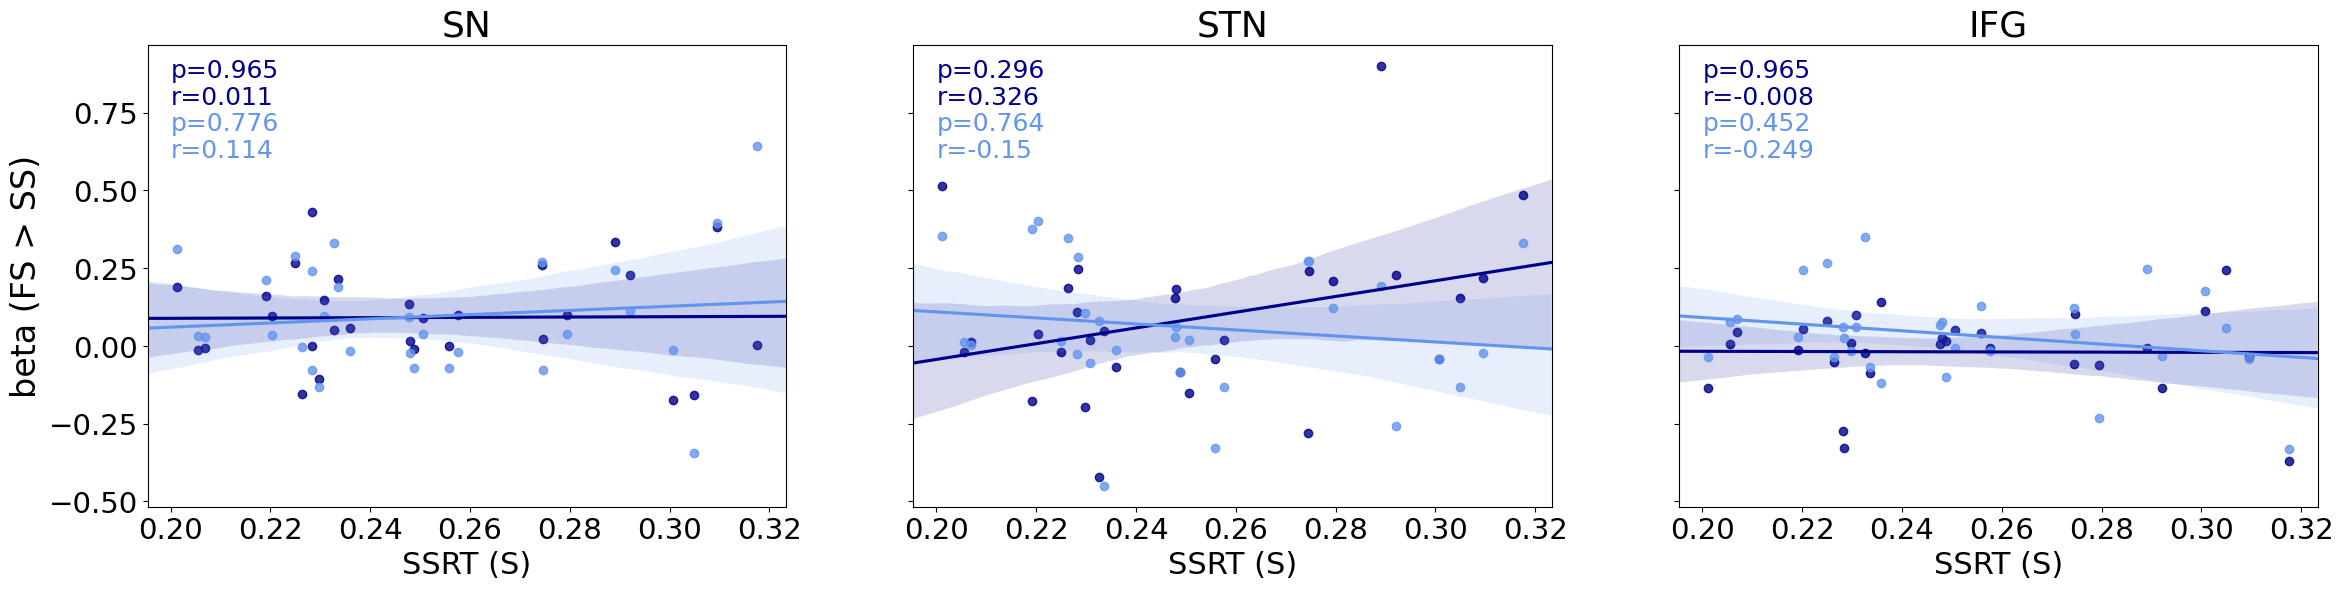

In [81]:
betas = load_betas('ss') 
# dmc = pd.read_csv('scott/dmc_params_final.tsv', sep='\t') 
# dmc.drop(dmc.tail(1).index,inplace=True) # drop last n rows dmc.reset_index() 
# dmc['SSRT'] = dmc['muS'] + dmc['tauS']

dmc = load_dmc_params()

all_subs = sorted(list(set(betas.subject).intersection(dmc.index)),key=int)

dmc = dmc.loc[dmc.index.isin(all_subs)].reset_index(drop=True) 
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

dmc_betas = pd.concat([dmc, betas], axis=1) 
dmc_betas = dmc_betas.loc[:,~dmc_betas.columns.duplicated()]

dmc_betas = dmc_betas.drop(['event type','regressor','covariate'],axis=1)

        
## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = dmc_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)

# print(stat_df)

# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=dmc_betas['SSRT'], y=dmc_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (SS)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(dmc_betas["SSRT"], dmc_betas[this_roi])[0].round(3)}', (0.3,0.555),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(dmc_betas["SSRT"], dmc_betas[this_roi])[0].round(3)}', (0.3,0.415),fontsize=18,color='cornflowerblue')
#     stat_df.loc[stat_df.index == r,'p_corrected']
# plt.annotate('actual group', xy=(x+0.2,y), xytext=(x+0.3, 300),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7))

# ---------------------------------------------

betas_fs = load_betas('fs')
betas_ss = load_betas('ss')
betas_fs.iloc[:,4:] = betas_fs.iloc[:,4:] - betas_ss.iloc[:,4:]
betas = betas_fs
# dmc = pd.read_csv('scott/dmc_params_final.tsv', sep='\t') 
# dmc.drop(dmc.tail(1).index,inplace=True) # drop last n rows dmc.reset_index() 
# dmc['SSRT'] = dmc['muS'] + dmc['tauS']

dmc = load_dmc_params()

all_subs = sorted(list(set(betas.subject).intersection(dmc.index)),key=int)

dmc = dmc.loc[dmc.index.isin(all_subs)].reset_index(drop=True) 
betas = betas.loc[betas.subject.isin(all_subs)].reset_index(drop=True)

dmc_betas = pd.concat([dmc, betas], axis=1) 
dmc_betas = dmc_betas.loc[:,~dmc_betas.columns.duplicated()]

dmc_betas = dmc_betas.drop(['event type','regressor','covariate'],axis=1)

        
## correct for multiple comparisons
# pick regions we expect correlations with
# dmc_betas = 
dmc_betas_cor = dmc_betas[['subject','IFG-l','IFG-r','SN-l','SN-r','STN-l','STN-r','SSRT']] # 'IFG-l','IFG-r',

dmc_betas_cor = dmc_betas_cor.set_index('subject')
dmc_betas_cor = dmc_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = dmc_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, dmc_betas_cor.loc[dmc_betas_cor.ROI=='SSRT','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)

# print(stat_df)

# left anf right hemispehere of ROIs correlated with SSRT
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['SN','STN','IFG']
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=dmc_betas['SSRT'], y=dmc_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_xlabel('SSRT (S)', fontsize=22)
        ax[i].set_title(r,fontsize=26)
        if i == 0:
            ax[i].set_ylabel('beta (FS > SS)',fontsize=24)
        else:
            ax[i].set_ylabel('',fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=21)
        if '-l' in this_roi:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(dmc_betas["SSRT"], dmc_betas[this_roi])[0].round(3)}', (0.2,0.775),fontsize=18,color='darkblue')
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(dmc_betas["SSRT"], dmc_betas[this_roi])[0].round(3)}', (0.2,0.605),fontsize=18,color='cornflowerblue')
#     stat_df.loc[stat_df.index == r,'p_corrected']
# plt.annotate('actual group', xy=(x+0.2,y), xytext=(x+0.3, 300),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7))



# MSIT single model vs INC betas

In [94]:
betas_inc = load_betas('inc').drop(['event type', 'covariate', 'regressor'], axis=1)
betas_con = load_betas('con').drop(['event type', 'covariate', 'regressor'], axis=1)
cog = load_single_msit()

cog.subject = cog['Unnamed: 0'].astype(str)
cog= cog.drop('Unnamed: 0', axis=1)

# subs = [x for x in betas.subject if any(s in x for s in cog.subject)] 
# all_subs =[x for x in subs if any(s in x for s in betas.subject)] 
all_subs = sorted(list(set(betas_inc.subject).intersection(cog.subject)),key=int)
cog = cog.loc[cog.subject.isin(all_subs)].reset_index(drop=True)
betas_inc = betas_inc.loc[betas_inc.subject.isin(all_subs)].reset_index(drop=True)

cog_betas = pd.concat([cog, betas_inc], axis=1)
cog_betas = cog_betas.loc[:,~cog_betas.columns.duplicated()]

betas_con = betas_con.loc[betas_con.subject.isin(all_subs)].reset_index(drop=True)

inc_con_betas = betas_inc.set_index('subject') - betas_con.set_index('subject')
inc_con_betas = inc_con_betas.reset_index()
cog_inc_con_betas = pd.concat([cog, inc_con_betas], axis=1)
cog_inc_con_betas = cog_inc_con_betas.loc[:,~cog_inc_con_betas.columns.duplicated()]

cog_inc_con_betas['vIncongruent'] = cog_inc_con_betas['vSimon'] + cog_inc_con_betas['vFlank'] #+ cog_inc_con_betas['vMatch']# + cog_inc_con_betas['v']

In [95]:
print(len(all_subs)) # there should be 36

36


In [96]:
## correct for multiple comparisons

# pick regions we expect correlations with
# dmc_betas = 
cog_inc_con_betas_cor = cog_inc_con_betas[['subject','ACC-l','ACC-r','IFG-l','IFG-r','CN-l','CN-r','vIncongruent']] # 'Tha-l','Tha-r''Ins-l','Ins-r',

cog_inc_con_betas_cor = cog_inc_con_betas_cor.set_index('subject')
cog_inc_con_betas_cor = cog_inc_con_betas_cor.melt(var_name='ROI',value_name='beta',ignore_index=False)

tmp = cog_inc_con_betas_cor.groupby('ROI')['beta'].apply(lambda x: scipy.stats.pearsonr(x, cog_inc_con_betas_cor.loc[cog_inc_con_betas_cor.ROI=='vIncongruent','beta']))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)

stat_df['p_corrected'] = stat_df['p_corrected'].astype(float).round(3)
stat_df.loc[stat_df.index=='ACC-r','p_corrected'] = ' 0.003'

stat_df

,t,p,fdr_significant,p_corrected
ACC-l,0.312679,0.063351,False,0.096
ACC-r,0.477337,0.003242,True,0.003
CN-l,0.178091,0.298726,False,0.349
CN-r,0.143710,0.403051,False,0.403
IFG-l,0.307302,0.068282,False,0.096
IFG-r,0.488394,0.002510,True,0.008
vIncongruent,1.000000,0.000000,True,0.0


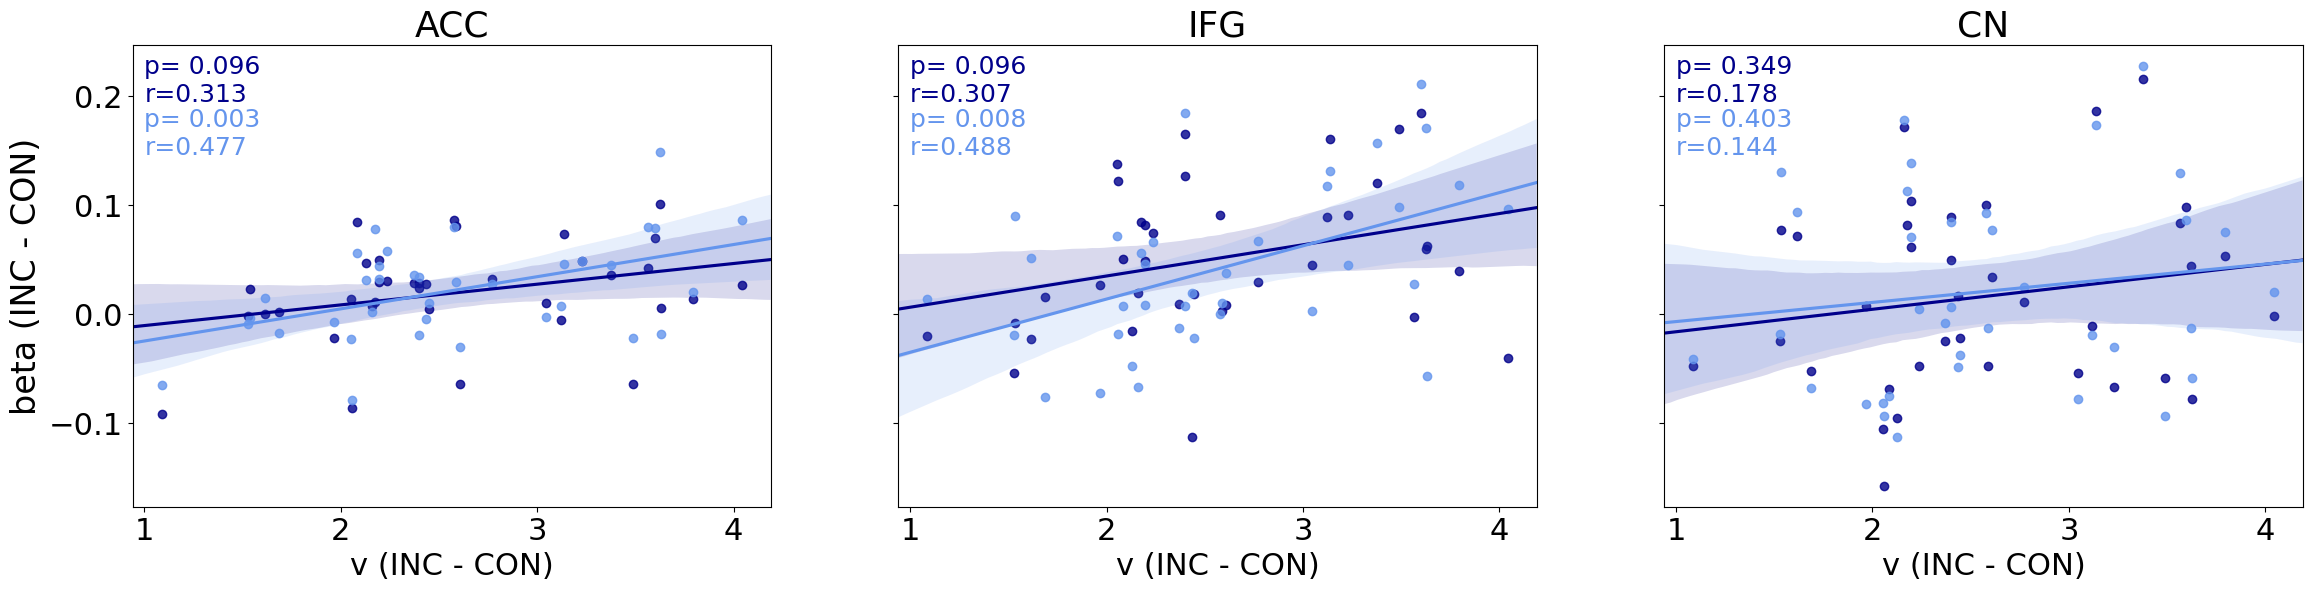

In [101]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(28,6))
# fig.suptitle('Correlations between cognitive estimates and betas')
ax = axes.ravel()
rois = ['ACC','IFG','CN'] # 'Ins',,'Tha'
hemis = ['l','r']
for i, r in enumerate(rois):
    for h in hemis:
        this_roi = r+'-'+h
        coloring = 'darkblue' if h == 'l' else 'cornflowerblue'
        sns.regplot(x=cog_inc_con_betas['vIncongruent'], y=cog_inc_con_betas[this_roi],ax=ax[i], truncate=False, ci=95, color=coloring)
        ax[i].set_title(r,fontsize=26)
        if i in [0,3]:
            ax[i].set_ylabel('beta (INC - CON)', fontsize=24)
        else:
    #         ax[i].set_xlabel('')
            ax[i].set_ylabel('')
        ax[i].set_xlabel('v (INC - CON)', fontsize=22)
        ax[i].tick_params(axis='both', which='major', labelsize=22)
        if '-l' in this_roi:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_inc_con_betas["vIncongruent"], cog_inc_con_betas[this_roi])[0].round(3)}', (1,0.195),fontsize=18, color='darkblue')    
        else:
            ax[i].annotate(f'p={stat_df.loc[stat_df.index == this_roi,"p_corrected"].to_string(index=False)}\nr={pearsonr(cog_inc_con_betas["vIncongruent"], cog_inc_con_betas[this_roi])[0].round(3)}', (1,0.146),fontsize=18, color='cornflowerblue')    

# ax[5].axis('off')
#     ax[11].axis('off')

fig.savefig('figure_download_scott/Figure15_new.pdf', bbox_inches='tight')

# correlate dmc sst params with mpwg msit params

In [32]:
betas = load_betas('ss') 
dmc = pd.read_csv('scott/dmc_params_final.tsv', sep='\t') 
dmc['subject'] = dmc.index
dmc.drop(dmc.tail(1).index,inplace=True) # drop last n rows dmc.reset_index() 
dmc['SSRT'] = dmc['muS'] + dmc['tauS'] 

In [33]:
subs_to_keep = [x for x in list(dmc.subject) if '25' not in x]
subs_to_keep = [x for x in list(subs_to_keep) if '35' not in x]
subs_to_keep = [x for x in list(subs_to_keep) if '41' not in x]

In [34]:
cog_all = cog.loc[cog['subject'].isin(subs_to_keep)].reset_index(drop=True)
dmc_all = dmc.loc[dmc['subject'].isin(subs_to_keep)].reset_index(drop=True)
dmc_all = dmc_all.drop('subject',axis=1)

In [35]:
all_params = pd.concat([cog_all,dmc_all],axis=1)
all_params = all_params.drop('subject',axis=1)

In [36]:
all_params

,t0,vFlank,vSimon,vPos.1,vPos.2,vMatch,v,B,mu.true,sigma.true,tau.true,muS,sigmaS,tauS,tf,gf,SSRT
0,0.116518,0.758674,0.329005,0.323188,0.001097,2.234546,0.512992,1.694611,0.456349,0.078182,0.128914,0.223609,0.037816,0.085955,-2.679217,-2.689964,0.309564
1,0.260541,1.480560,0.953821,0.041748,-0.073539,3.555659,0.269849,1.790557,0.517536,0.092264,0.118184,0.199658,0.026798,0.028707,-3.032988,-2.436859,0.228365
2,0.300498,1.481831,2.147224,0.591564,0.400802,2.795917,-0.205320,1.480168,0.489644,0.101303,0.116607,0.216754,0.024266,0.030964,-3.073604,-2.413314,0.247718
3,0.345221,0.978401,1.216770,0.346481,-0.230680,3.406643,-0.153772,1.794165,0.472486,0.049382,0.081652,0.218082,0.030582,0.037679,-2.994407,-2.698170,0.255761
4,0.288898,1.076583,1.081813,0.229073,-0.012847,3.653373,0.192134,2.114054,0.692897,0.108102,0.079541,0.186417,0.020777,0.014789,-3.140905,-2.062229,0.201206
5,0.252742,1.213545,0.314173,0.421842,-0.128926,4.255244,-0.517536,1.839931,0.506411,0.089964,0.118199,0.208996,0.014752,0.017428,-3.092924,-2.014602,0.226424
6,0.228628,0.804614,0.730962,0.140627,-0.425158,3.210494,0.173618,1.921053,0.585377,0.095368,0.095299,0.198524,0.024027,0.037385,-2.146197,-2.013122,0.235909
7,0.328258,1.736933,1.861576,0.622728,0.158040,4.199079,-0.572852,1.524634,0.691169,0.109192,0.074448,0.191760,0.030187,0.028520,-2.578925,-2.071197,0.220280
8,0.261823,0.710252,1.372796,0.867084,0.214496,1.881649,0.115178,1.234563,0.788336,0.156827,0.063803,0.194970,0.025951,0.024238,-3.102646,-1.576432,0.219208
9,0.178584,0.867480,1.099500,0.311802,0.164929,2.800203,0.339714,2.018508,0.560168,0.192350,0.098861,0.193522,0.040382,0.037325,-2.827651,-1.847032,0.230847


# full correlation heatmaps

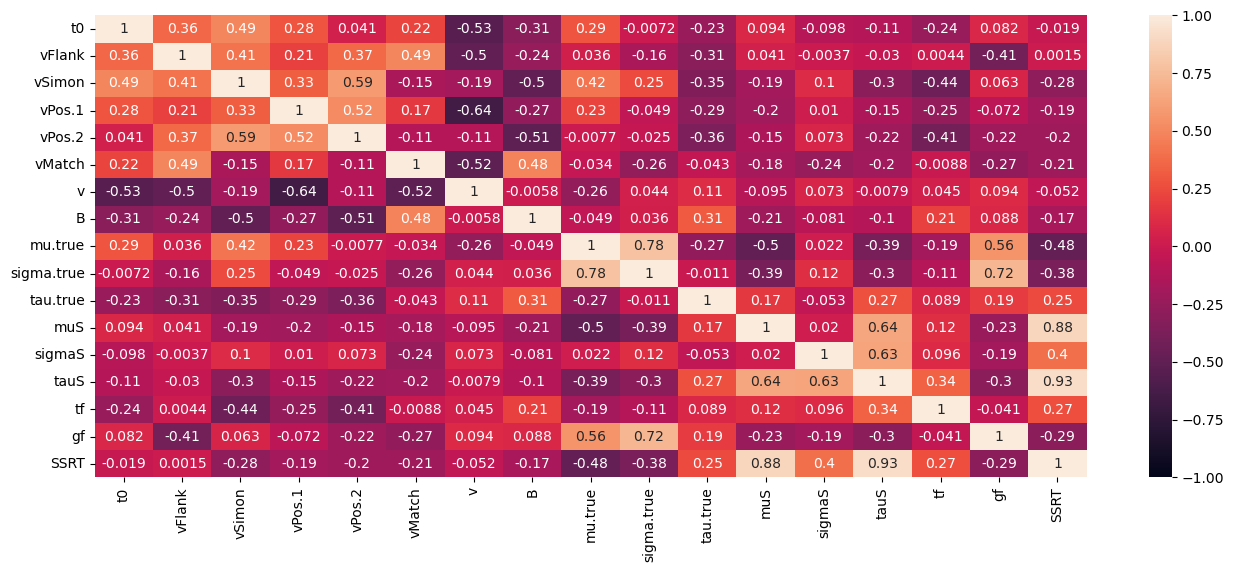

In [62]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(all_params.corr(), vmin=-1, vmax=1, annot=True)


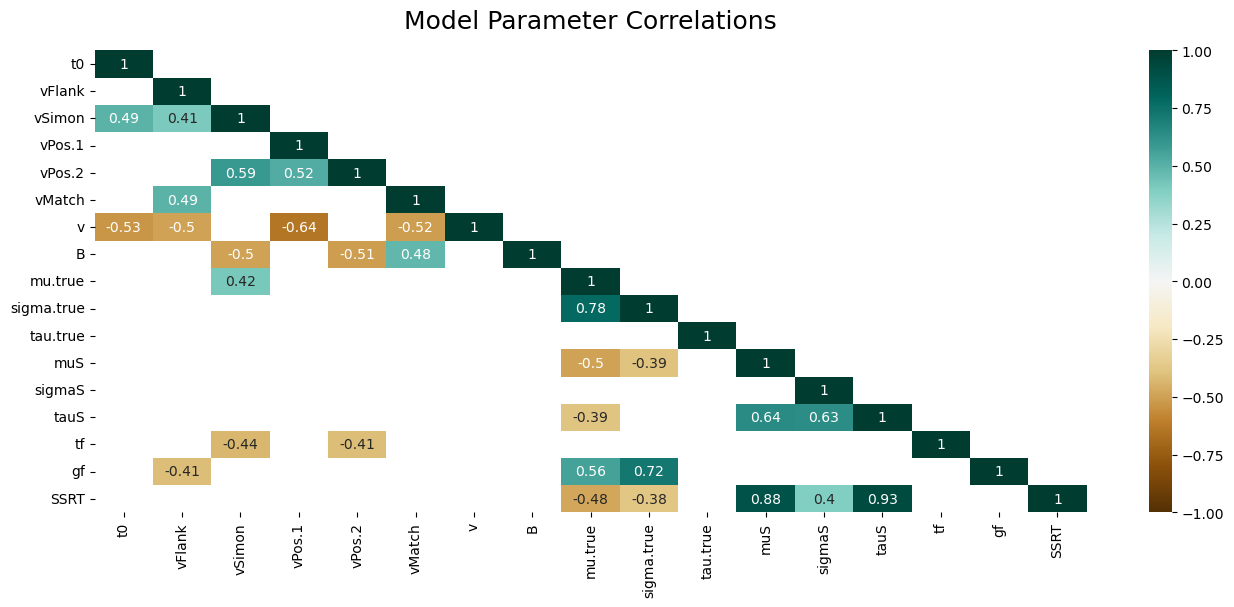

In [38]:
import scipy
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
# mask = np.triu(np.ones_like(all_params.corr(), dtype=np.bool))
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = scipy.stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

p_values = corr_sig(all_params)
mask = np.invert(np.tril(p_values<0.05))

heatmap = sns.heatmap(all_params.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Model Parameter Correlations', fontdict={'fontsize':18}, pad=16);

/tmp/ipykernel_1196687/400599360.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(all_params.corr(), dtype=np.bool))


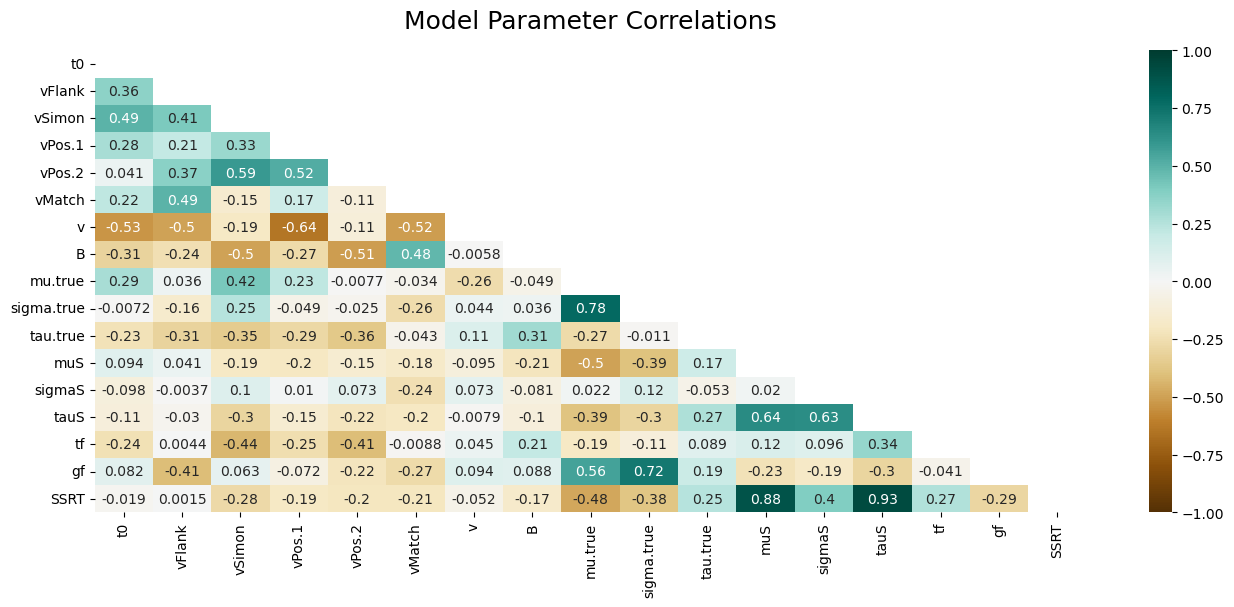

In [39]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(all_params.corr(), dtype=np.bool))
heatmap = sns.heatmap(all_params.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Model Parameter Correlations', fontdict={'fontsize':18}, pad=16);

### do correlation with pnormed gf and tf values

In [40]:
adj_params = all_params.copy()
adj_params['tf'] = scipy.stats.norm.cdf(adj_params['tf'])
adj_params['gf'] = scipy.stats.norm.cdf(adj_params['gf'])

In [41]:
adj_params.rename(columns={'vFlank':'$\u03BD_{Flank}$','vSimon':'$\u03BD_{Simon}$','vPos.1':'$\u03BD_{pos1}$','vPos.2':'$\u03BD_{pos2}$','vMatch':'$\u03BD_{Target}$','v':'$\u03BD_{0}$',
                           'mu.true':'$\u03BC_{go}$','sigma.true':'$\u03C3_{go}$','tau.true':'$\u03C4_{go}$',
                           'muS':'$\u03BC_{stop}$','sigmaS':'$\u03C3_{stop}$','tauS':'$\u03C4_{stop}$'},inplace=True)

/tmp/ipykernel_1196687/3673163177.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(adj_params.corr(), dtype=np.bool))


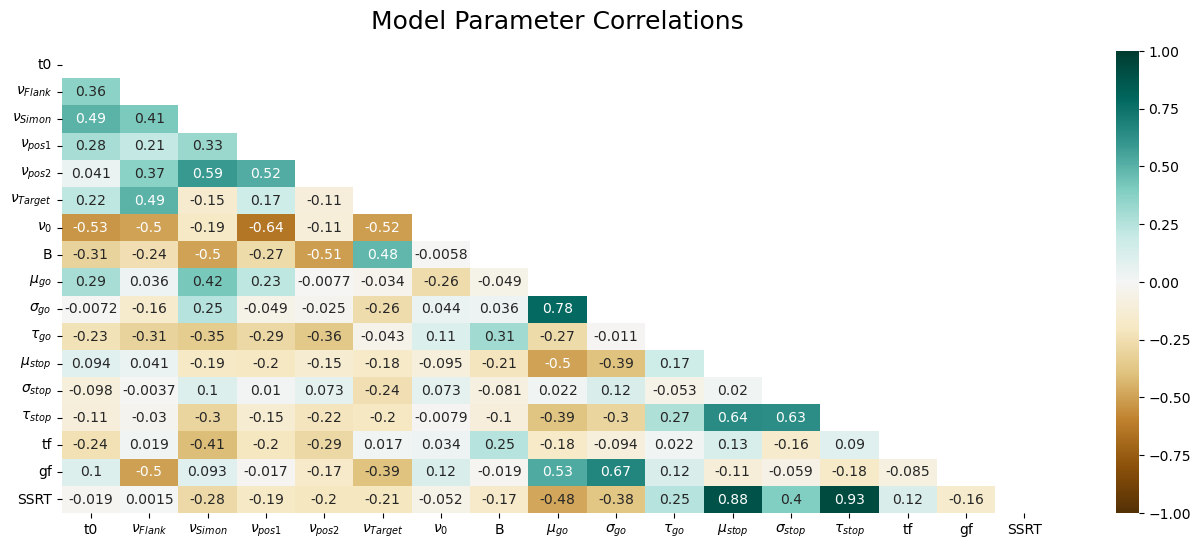

In [42]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(adj_params.corr(), dtype=np.bool))
heatmap = sns.heatmap(adj_params.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Model Parameter Correlations', fontdict={'fontsize':18}, pad=16);

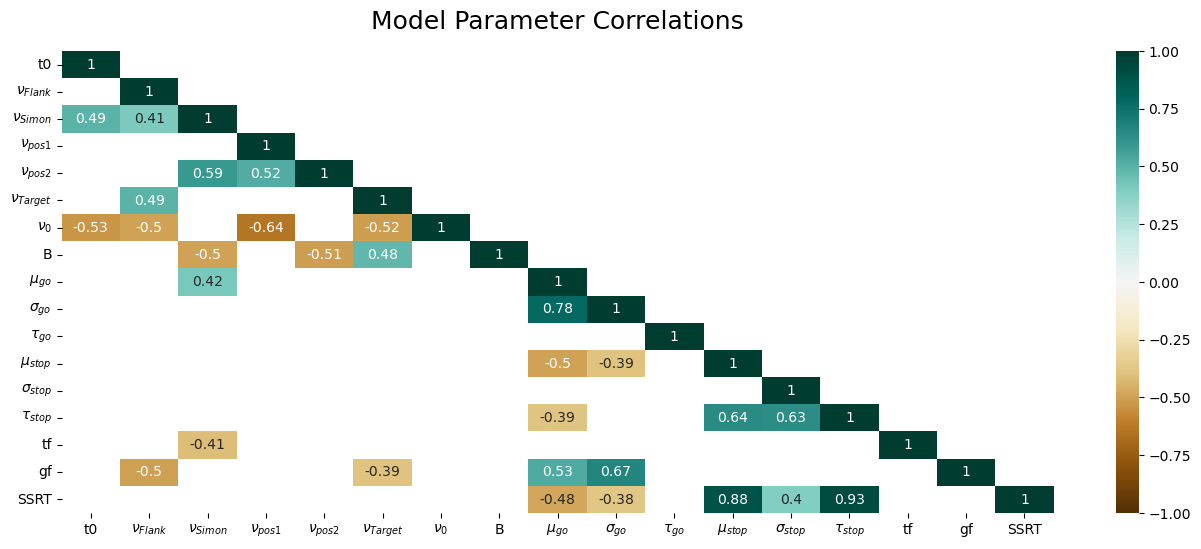

In [43]:
import scipy
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
# mask = np.triu(np.ones_like(all_params.corr(), dtype=np.bool))
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = scipy.stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

p_values = corr_sig(adj_params)
mask = np.invert(np.tril(p_values<0.05))

heatmap = sns.heatmap(adj_params.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Model Parameter Correlations', fontdict={'fontsize':18}, pad=16);

/tmp/ipykernel_1196687/1290071173.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(adj_params.corr(), dtype=np.bool))


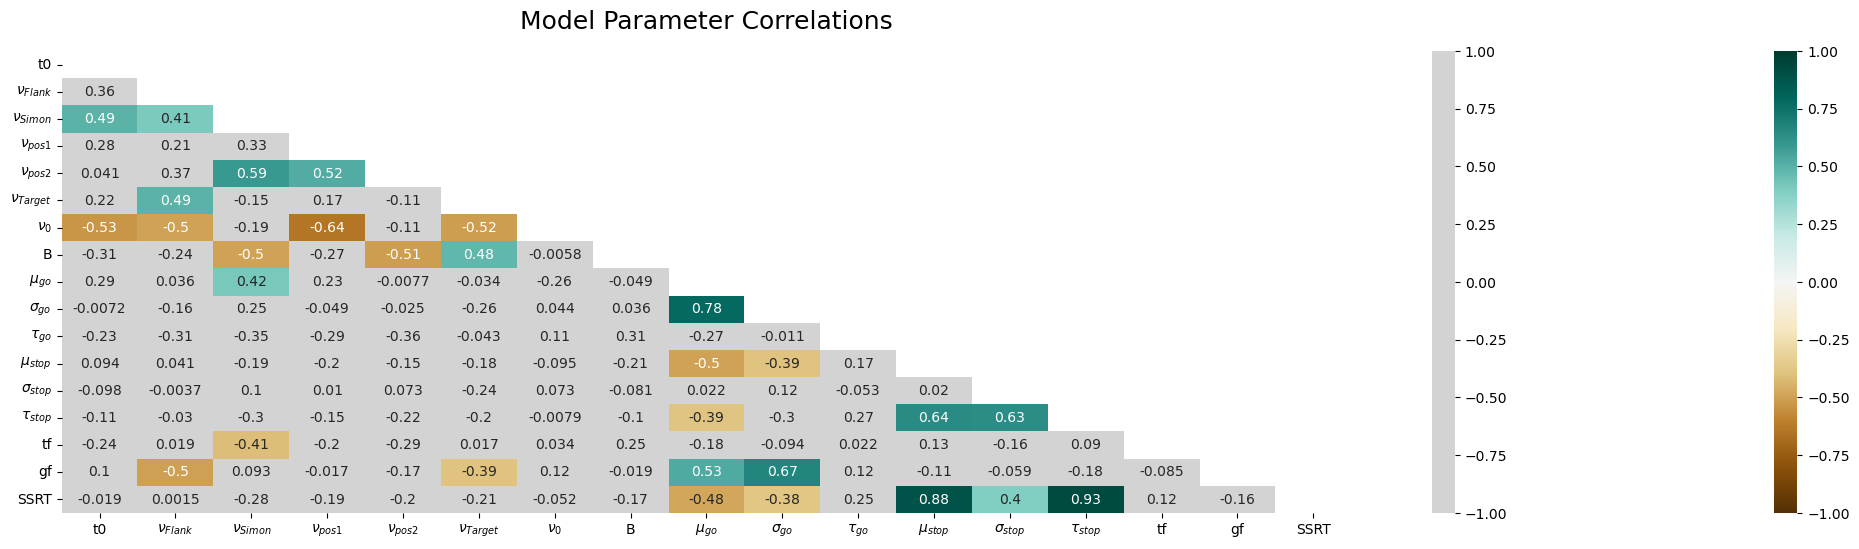

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
# get the p value for pearson coefficient, subtract 1 on the diagonal
pvals = adj_params.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*adj_params.corr().shape)
# set the significance threshold
psig = 0.05

plt.figure(figsize=(26,6))

mask = np.triu(np.ones_like(adj_params.corr(), dtype=np.bool))

heaty = sns.heatmap(adj_params.corr()[pvals<psig], mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
sns.heatmap(adj_params.corr()[pvals>=psig], mask=mask, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette(['lightgrey']))
heaty.set_title('Model Parameter Correlations', fontdict={'fontsize':18}, pad=16);

# colors = [sns.color_palette("Greys", n_colors=1, desat=1)[0]]
# texts = [f"n.s. (at {psig})"]
# patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# plt.legend(handles=patches, bbox_to_anchor=(.85, 1.05), loc='center')
# sns.heatmap(adj_params.corr()[pvals<psig], annot=True, square=True)

# # add another heatmap with colouring the non-significant cells
# sns.heatmap(adj_params.corr()[pvals>=psig], annot=True, square=True, cbar=False, 
#             cmap=sns.color_palette("Greys", n_colors=1, desat=1))



In [45]:
import pingouin

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


/tmp/ipykernel_1196687/1427627482.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(adj_params.corr(), dtype=np.bool))


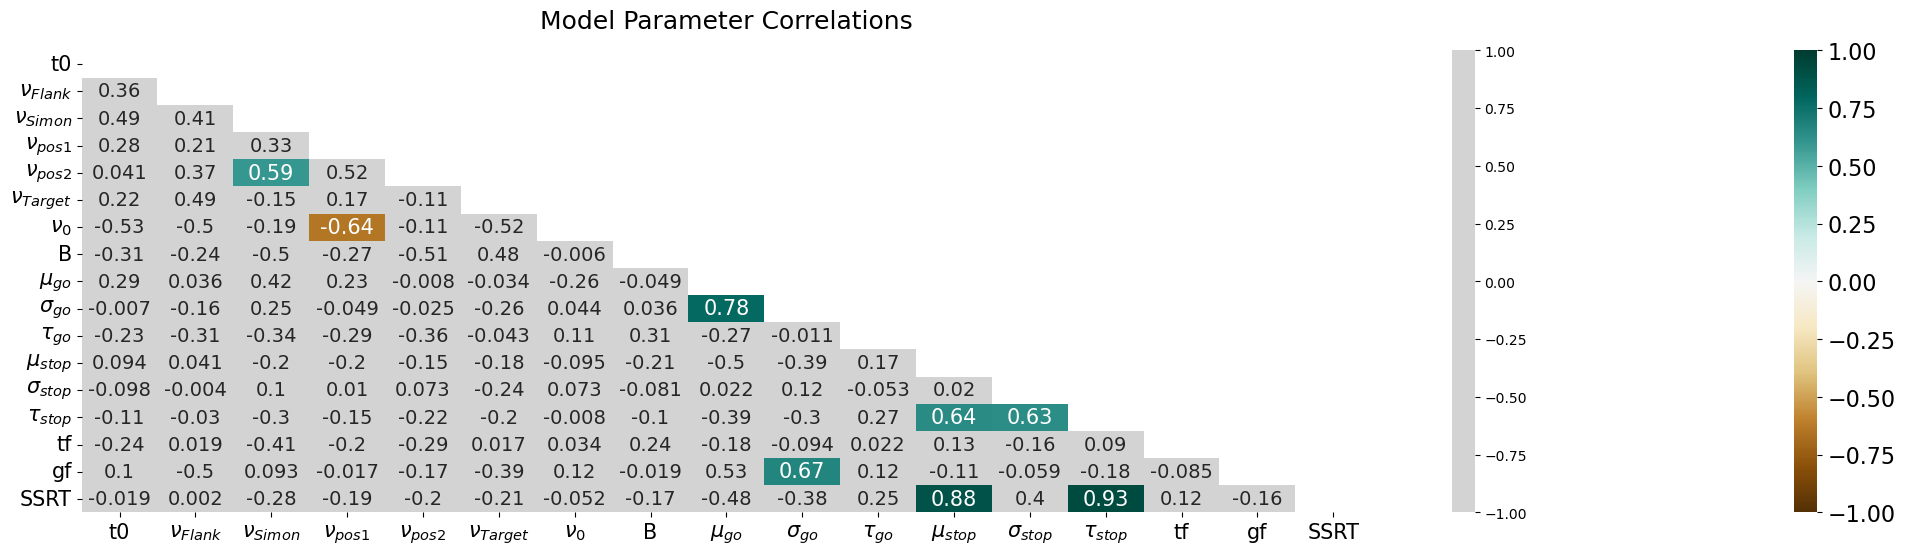

In [46]:
# adjust everything for fdr
fdr_cor = pingouin.rcorr(adj_params, method='pearson', upper='pval', decimals=3, padjust='fdr_bh', stars=False).replace('-',1).apply(pd.to_numeric)
pvals = fdr_cor.transpose()
psig = 0.05

plt.figure(figsize=(26,6))

mask = np.triu(np.ones_like(adj_params.corr(), dtype=np.bool))
# sns.set(font_scale=1.3) 
heaty = sns.heatmap(fdr_cor[pvals<psig], mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG',annot_kws={"size": 15})
sns.heatmap(fdr_cor[pvals>=psig], mask=mask, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette(['lightgrey']), annot_kws={"size": 14})
heaty.set_title('Model Parameter Correlations', fontdict={'fontsize':18}, pad=16);
heaty.tick_params(labelsize=15)
cbar = heaty.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=16)

